# The Response of Sea Surface Temperature to Rain
Ongoing summary of research/analysis to serve as the skeleton for the eventual publication.

## Variable Names

$\Delta SST_{skin}$ - departure of skin temperature (KT15) from 3-minute mean prior to rain onset

$t_{*SST}$ - time from rain onset to maximum SST response (maximum $\Delta SST_{skin}$)

$L_{rain}$ - length of rain event

$t_{*rain}$ - time from rain onset to peak rain rate

## Overview of DYNAMO dataset

The figure below shows a series of histograms of relevant variables for each of the 103 identified rain events on DYNAMO.
The events are largely ~1hr long and deposit ~15mm rain, with only a few very long events (>10hrs). The mean $\Delta SST_{skin}$ due to rain is $-0.51 ^\circ C$.

![Histograms](Histograms v1.png)


## Relationships between variables

The figure below attempts to relate both the maximum skin temperature deviation ($\Delta SST_{skin}$) and the time between rain onset and maxiumum skin temperature deviation ($t_{*SST}$) to other relevant parameters.
![Scatterplots](Scatterplots v1.png)

The relationship between $t_{*rain}$ and $t_{*SST}$ looks fairly robust and close to 1:1 (red line). It makes some intuitive sense that the time period of the largest rain rate would tend to correspond to the time period of the largest SST deviation.

The other relationship that may have some legs is between $L_{rain}$ vs. $t_{*SST}$. However, this correspondence may just reflect the agreement between $t_{*rain}$ and $t_{*SST}$, in that longer rain events may tend to take longer to reach their maximum rain rate. **Plot $L_{rain}$ vs. $t_{*rain}$ and verify.** 

## Normalized timeseries of temperature deviation

The figure below shows a bin-averaged timeseries of all 103 rain events, where rain onset for each event corresponds to T=0, and the timescale of the event is normalized by $t_{*SST}$, the time it takes to reach the maximum SST deviation. This means that the maximum $\Delta SST_{skin}$ always occurs at T=1. 

![Timeseries](Timeseries_v1.png)

It would seem to make more sense to **normalize the timescale in this figure by $t_{*rain}$ rather than $t_{*SST}$**, especially given the good correspondence between the two.

The **locations of the bins** also seem arbitrary and poorly chosen, as there is no bin centered on 0 or 1, the two most important parts of the timescale. 

There is very close temporal alignment of the trends in $\Delta SST_{skin}$, $\Delta T_{bulk}$, and $\Delta T_{air}$, with the drop in SST about double the drop in bulk water temperature. It is interesting that there is no time lag between the trends in SST and bulk temperature - likely due to some combination of these two factors:
    - insufficient temporal resolution between bins to see the delay
    - downward mixing occuring on sufficiently short timescales
   

### Deb's scripts:
*SST_rain_comparison_ID_rainpeaks.m*    does the basic peak detection and collates met data from Edson.

*SST_rain_comparison_bin_average_interim.m*   plots some histograms and scatterplots

*SST_rain_comparison_with_anomaly.m*    Collates variables into structure Var

*SST_rain_comparison_peak_response.m*   Adds times to max SST response, time to recover, etc.

*SST_rain_comparison_bin_average_more.m*  bin averages to create composite event - scales to beginning of event, and produces unscaled time as well (want scaled!)

*SST_rain_comparison_bin_average_long_short.m*   bin averages to create
composite but selects out long events

## Overview of Falkor Dataset(s)

There is a major challenge in extending the rigor of the DYNAMO processing to the Falkor datasets:  **there was no rain sensor onboard the ship.** In 2016, the catamaran had a rain sensor, and in 2019, the SPIP had a rain sensor, but this limits us to rain events in which SPIP or Cat were in the waterfor the entire duration of the event. There are only 5 rain events recorded by SPIP in 2019 from start to end, and they are all extremely mild rain rates. 

However, there is another event from which we can get some really interesting information. On November 22, 2019, SPIP captured the process of a diurnal warm layer breaking down in the presence of an oncoming rain event, followed by the development of a cold freshwater lens on the surface in response to increased rainfall and decreasing wind forcing:

![Dep2RainSPIP](SPIP_SummaryPlot_deployment2_RainEvent.png)

Let's take a look at this event as recorded by the KT-15s:
**Zappa can you provide the reference for the sky-correction algorithm?**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
# Need 3 functions for the KT15s:
#   1. import KT15 data from LabView output (Level 0) and output clean Level 1 product
#   2. import l1 products of blackbody runs and output linear calibration coefficients
#   3. import l1 products of data runs, apply lab calibration and sky correction

def KT15_import(data_folder):
    # --------------------------------------------------------------------------------------------
    #
    #
    # --------------------------------------------------------------------------------------------
    
    
    
def KT15_labcalibration(l1data_path):
    # --------------------------------------------------------------------------------------------
    #
    #
    # --------------------------------------------------------------------------------------------
    
    

def KT15_calibrate_skycorrect(l1data_path, sea_slope, sea_yint, sky_slope, sky_yint):
    # --------------------------------------------------------------------------------------------
    # This function takes data from a pair of up- and down-looking KT15.82 8um-14um infrared 
    # radiometers, applies a linear calibration based on mean coefficients provided from blackbody 
    # calibrations in the lab, and calculates a final value for the true SST corrected for 
    # reflections from the sky, following SOURCE.
    #
    # Inputs:
    #    l1data_path - path to Level 1 Data Product generated by KT15_import function
    #    sea_slope   - slope of blackbody calibration for down-looking instrument
    #    sea_yint    - y-intercept of blackbody calibration for down-looking instrument
    #    sky_slope   - slope of blackbody calibration for up-looking instrument
    #    sky_yint    - y-intercept of blackbody calibration for up-looking instrument
    #
    # Outputs:
    #    SST         - final radiometric Sea Surface Temperature for the skin layer
    #
    # Dependencies:
    #    numpy
    #    pandas
    #    matplotlib?
    # --------------------------------------------------------------------------------------------

    #import a KT15 labview data file:
    kt = pd.read_csv('../Data/Working/Falkor19/KT15/2019_Falkor_325_043435.txt',                                   #filename to read in
                     delimiter='\s+', skiprows=1, header=None,                                                     #treat whitespace as the delimeter, ignore the header line
                     usecols=[0,1,2,3,4,5], names=['Date','Time','SeaRef','SeaTemp','SkyRef','SkyTemp'],           #use the first 6 columns, and name them as specified
                     parse_dates={'DateTime':[0,1]}, index_col=0,                                                  #parse the first two columns as a single DateTime, and make it the index column
                     na_values=['AMB'],                                                                            #list of other things the parser might encounter in these files, that should be treated like NaNs
                     dtype={'SeaRef':np.float64, 'SeaTemp':np.float64, 'SkyRef':np.float64, 'SkyTemp':np.float64}, #explicitly specify that data columns must be 64-bit floating point numbers
                     error_bad_lines=False, warn_bad_lines=True)                                                   #if there is a bad line in the data file, drop it from the file and show a warning, but continue parsing
    kt.dropna(axis='index',how='any',inplace=True)                                                                 #drop any rows that have a NaN value in them

    #apply blackbody calibration
    SkyTemp_Cal = (kt.SkyTemp - sky_yint)/sky_slope
    SeaTemp_Cal = (kt.SeaTemp - sea_yint)/sea_slope

    #apply sky correction - what is the source for these coefficients?
    K0u = -1.9151
    K1u = 0.041767
    K2u = -0.00033291
    K3u = 1.0715e-06
    K4u = -8.651e-10
    K5u = K6u = K7u = K8u = 0 

    K0d = -82.135
    K1d = 2.293
    K2d = -0.020287
    K3d = 6.7301e-05
    K4d = -5.2395e-08
    K5d = K6d = K7d = K8d = 0

    y0 = 136.33
    A = 20.927
    power = 0.40045

    RadTempSKY = kt.SkyTemp_Cal + 273.16
    RadTempSEA = kt.SeaTemp_Cal + 273.16
    ReflectedSkyRad = K0u + K1u*RadTempSKY + K2u*RadTempSKY**2 + K3u*RadTempSKY**3 + K4u*RadTempSKY**4 + K5u*RadTempSKY**5 + K6u*RadTempSKY**6 + K7u*RadTempSKY**7 + K8u*RadTempSKY**8
    TotalRad = K0d + K1d*RadTempSEA + K2d*RadTempSEA**2 + K3d*RadTempSEA**3 + K4d*RadTempSEA**4 + K5d*RadTempSEA**5 + K6d*RadTempSEA**6 + K7d*RadTempSEA**7 + K8d*RadTempSEA**8
    SSTRad = TotalRad - ReflectedSkyRad
    kt['SST'] = y0 + A*(SSTRad)**power - 273.16

,SeaRef,SeaTemp,SkyRef,SkyTemp
DateTime,,,,
2019-11-21 04:34:36.153,31.51,27.94,31.69,22.40
2019-11-21 04:34:36.953,31.51,27.98,31.69,22.38
2019-11-21 04:34:37.754,31.51,27.90,31.69,22.31
2019-11-21 04:34:38.554,31.51,27.92,31.69,22.33
2019-11-21 04:34:39.354,31.51,27.94,31.69,22.31


In [ ]:
#import a KT15 labview data file:
kt = pd.read_csv('../Data/Working/Falkor19/KT15/2019_Falkor_325_043435.txt',                                   #filename to read in
                 delimiter='\s+', skiprows=1, header=None,                                                     #treat whitespace as the delimeter, ignore the header line
                 usecols=[0,1,2,3,4,5], names=['Date','Time','SeaRef','SeaTemp','SkyRef','SkyTemp'],           #use the first 6 columns, and name them as specified
                 parse_dates={'DateTime':[0,1]}, index_col=0,                                                  #parse the first two columns as a single DateTime, and make it the index column
                 na_values=['AMB'],                                                                            #list of other things the parser might encounter in these files, that should be treated like NaNs
                 dtype={'SeaRef':np.float64, 'SeaTemp':np.float64, 'SkyRef':np.float64, 'SkyTemp':np.float64}, #explicitly specify that data columns must be 64-bit floating point numbers
                 error_bad_lines=False, warn_bad_lines=True)                                                   #if there is a bad line in the data file, drop it from the file and show a warning, but continue parsing
kt.dropna(axis='index',how='any',inplace=True)                                                                 #drop any rows that have a NaN value in them
kt

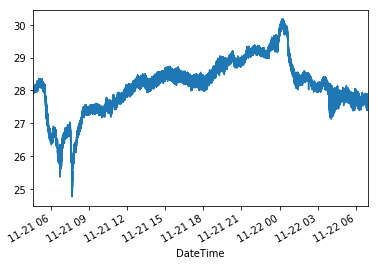

In [26]:
kt.SeaTemp.plot()